### Digit Recognition Project

In [1]:
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import MinMaxScaler

from tqdm import tqdm

import matplotlib.pyplot as plt

RNG_SEED = 42 # Meaning of Life

### Load data

In [2]:
labeled_images = np.load("labeled_images.npy")
labeled_digits = np.load("labeled_digits.npy")

autograder_images = np.load("autograder_images.npy")

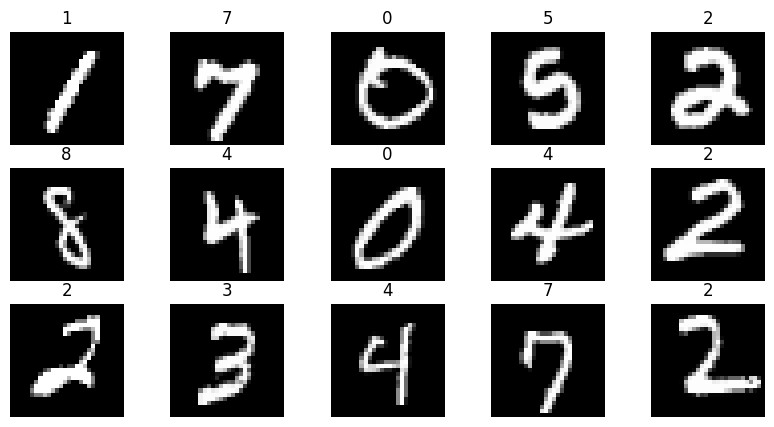

In [3]:
# this is an array containing all the 3750 images of size 28 times 28 pixels:
labeled_images.shape

# Draw all images
fig, axes = plt.subplots(3, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(labeled_images[i], cmap='gray')
    ax.set_title(labeled_digits[i])
    ax.axis('off')
plt.show()

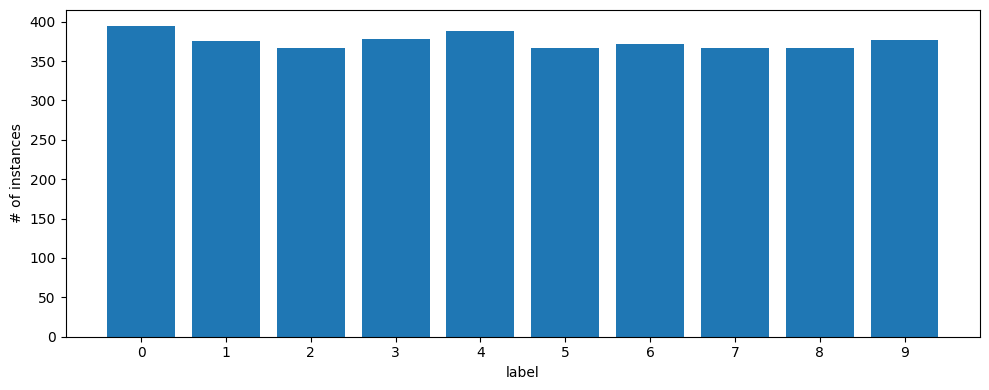

In [12]:
unique, counts = np.unique(labeled_digits, return_counts=True)

fig, ax = plt.subplots(figsize = (10, 4))
ax.bar(unique, counts)

ax.set_xticks(unique)
ax.set_xlabel("label")
ax.set_ylabel("# of instances")

fig.tight_layout()
plt.show()

In [ ]:
baseline_accuracy = counts[0] / len(labeled_digits) # 3750 is the amount of entries

baseline_accuracy

395


### Scale data

In [16]:
scaler = MinMaxScaler()
labeled_images_reshaped = labeled_images.reshape(-1, 1)
scaled_labeled_images = scaler.fit_transform(labeled_images_reshaped).reshape(labeled_images.shape)

In [17]:
# this is an array containing the digit corresponding to each image:
labeled_digits[0:10]

array([1, 7, 0, 5, 2, 8, 4, 0, 4, 2])

# Regression with Default Hyperparameters

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = scaled_labeled_images.reshape(scaled_labeled_images.shape[0], -1) # replace with the real one
y = labeled_digits # replace with the real on 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RNG_SEED)

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [19]:
models = [('Decision tree', DecisionTreeClassifier(random_state=RNG_SEED)), 
          ('k-Neighbors', KNeighborsClassifier()),
          ('SVC', SVC(random_state=RNG_SEED)), 
          ('SGD', SGDClassifier(random_state=RNG_SEED, loss='log_loss'))]

In [26]:
accuracies = {}

for name, model in tqdm(models):
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    accuracies[name] = accuracy_score(y_test, y_pred)
    
print(accuracies)

100%|██████████| 4/4 [00:03<00:00,  1.01it/s]

{'Decision tree': 0.7146666666666667, 'k-Neighbors': 0.9137777777777778, 'SVC': 0.9351111111111111, 'SGD': 0.8497777777777777}


In [ ]:

estimate = np.array([0.7]) # TODO Replace this with your estimate of the accuracy on new data
prediction = np.array([-1] * len(autograder_images)) # TODO Replace this with your predictions of your best model
# For example using something like:
# prediction = my_super_duper_model.predict(autograder_images) 

result = np.append(estimate, prediction)

# The code below will write your estimate and prediction to a file named autograder.txt
# You will need to upload this file to the Vocareum autograder
pd.DataFrame(result).to_csv("autograder.txt", index=False, header=False)

# Hyperparameter Optimization with GridSearch

In [27]:
from sklearn.model_selection import GridSearchCV

models = [('Decision tree', DecisionTreeClassifier(random_state=RNG_SEED)), 
          ('k-Neighbors', KNeighborsClassifier()),
          ('SVC', SVC(random_state=RNG_SEED)), 
          ('SGD', SGDClassifier(random_state=RNG_SEED, loss='log_loss'))]

res = {}
for name, model in tqdm(models):
    params = {} # this has to be defined per model
    if isinstance(model, DecisionTreeClassifier):
        params = {'criterion':['gini','entropy'], 'max_depth': [5, 10, 20, 30, None],
            'max_features': [None, 'sqrt', 'log2'], 'splitter': ['best', 'random'],  'min_samples_split': [2, 5, 10, 20], 'min_samples_leaf': [1, 2, 5, 10], }
    elif isinstance(model, KNeighborsClassifier):
        params = {'n_neighbors': [3, 5, 7, 9, 11],
         'weights': ['uniform', 'distance'],
         'leaf_size': [15, 20]}
    elif isinstance(model, SVC):
        params = {'C': [0.01, 0.1, 1, 10], 'gamma' : [0.001, 0.01, 0.1, 1], 'kernel': ['linear', 'poly']}
    elif isinstance(model, SGDClassifier):
        params = {'alpha': [0.0001, 0.001, 0.01], 'penalty': ['l2', 'l1'], 'fit_intercept': [True, False]}

    clf = GridSearchCV(model, params, cv=5)
    
    clf.fit(X_train, y_train)
    
    best_model = clf.best_estimator_
    y_pred = best_model.predict(X_test)
    
    res[name] = {
        "model": best_model,
        "best_params": clf.best_params_,
        "accuracy": accuracy_score(y_test, y_pred)
    }
    print(name, " done with accuracy ", accuracy_score(y_test, y_pred))

  0%|          | 0/4 [00:00<?, ?it/s]c:\Projects\stat-learning\practice_project_data\.env\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
 25%|██▌       | 1/4 [05:51<17:33, 351.20s/it]

Decision tree  done with accuracy  0.7457777777777778


 50%|█████     | 2/4 [05:54<04:53, 146.55s/it]

k-Neighbors  done with accuracy  0.9271111111111111


 75%|███████▌  | 3/4 [07:45<02:10, 130.28s/it]

SVC  done with accuracy  0.9235555555555556


100%|██████████| 4/4 [09:36<00:00, 144.02s/it]

SGD  done with accuracy  0.8826666666666667


100%|██████████| 1000/1000 [00:52<00:00, 18.93it/s]


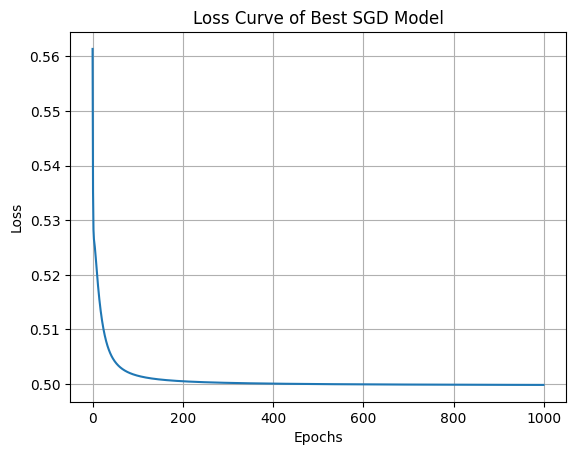

In [35]:
# Plot SGD
from sklearn.metrics import log_loss

best_params = res['SGD']['best_params']
best_sgd = SGDClassifier(**best_params, loss="log_loss", random_state=RNG_SEED)

loss = []
classes = np.unique(y)

for epoch in tqdm(range(1000)):
    best_sgd.partial_fit(X_train, y_train, classes=y)
    prob = best_sgd.predict_proba(X_train)

    epoch_loss = log_loss(y_train, prob)
    loss.append(epoch_loss)

plt.plot(loss)
plt.title("Loss Curve of Best SGD Model")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

### Prepare autograder submission

In the autograder you will need to provide two things: 1) estimate of the accuracy of your model on unseen data, 2) the predictions on the autograder images. For the autograder images we only provide the images and not the class labels. Thus, you cannot compute the accuracy on this data yourself - you need to estimate that with labeled data that is provided (labeled_images, labeled_digits). We will calculate the accuracy for you on the autograder data and you will receive an automatic grade based on this. 

In [5]:

estimate = np.array([0.7]) # TODO Replace this with your estimate of the accuracy on new data
prediction = np.array([-1] * len(autograder_images)) # TODO Replace this with your predictions of your best model
# For example using something like:
# prediction = my_super_duper_model.predict(autograder_images) 

result = np.append(estimate, prediction)

# The code below will write your estimate and prediction to a file named autograder.txt
# You will need to upload this file to the Vocareum autograder
pd.DataFrame(result).to_csv("autograder.txt", index=False, header=False)